# Modelo preditivo para a tendência do IBOVESPA

O objetivo desse projeto é desenvolver um modelo de Machine Learning capaz de prever se o índice IBOVESPA vai fechar em alta ou baixa no dia seguinte, com acuracidade mínima de 75% em um conjunto de teste composto pelos últimos 30 dias de dados.

> O Ibovespa é o principal indicador de desempenho das ações negociadas na B3 e reúne as empresas mais importantes do mercado de capitais brasileiro. Foi criado em 1968 e, ao longo desses 50 anos, consolidou-se como referência para investidores ao redor do mundo. [Referência](https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-amplos/ibovespa.htm)

## Importação das bibliotecas

In [279]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import talib



In [280]:
# Configurar paleta de cores e estilo
sns.set_style('whitegrid', {"grid.color": ".8", "grid.linestyle": "--"})
sns.set_palette(palette='mako')

## Aquisição dos dados

Utilizaremos os dados históricos do índice IBOVESPA, disponíveis publicamente no site do [br.investing](https://br.investing.com/indices/bovespa-historical-data)

In [281]:
df = pd.read_csv('Dados_Historicos_Ibovespa_2008-2025.csv', thousands='.', decimal=',', parse_dates=['Data'], date_format='%d.%m.%Y', index_col='Data')
df = df.rename_axis('ds').sort_index()
df.tail()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
ds,,,,,,
2025-06-12,137800,137127,137931,136175,"7,12B","0,49%"
2025-06-13,137213,137800,137800,136586,"8,63B","-0,43%"
2025-06-16,139256,137212,139988,137212,"7,62B","1,49%"
2025-06-17,138840,139256,139497,138293,"8,38B","-0,30%"
2025-06-18,138717,138844,139161,138443,"8,32B","-0,09%"


In [282]:
df.shape

(4315, 6)

In [283]:
# informações gerais do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4315 entries, 2008-01-18 to 2025-06-18
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Último    4315 non-null   int64 
 1   Abertura  4315 non-null   int64 
 2   Máxima    4315 non-null   int64 
 3   Mínima    4315 non-null   int64 
 4   Vol.      4314 non-null   object
 5   Var%      4315 non-null   object
dtypes: int64(4), object(2)
memory usage: 236.0+ KB


## Tratamento dos dados

Vamos transformar os dados brutos em um formato adequado para o treinamento de um modelo de Machine Learning.

In [284]:
# renomeando as colunas para os nomes padrões utilizados no mercado financeiro
colunas = {
  'Último': 'close',              # fechamento da negociação diária
  'Abertura': 'open',             # início da negociação diária
  'Máxima': 'high',               # valor máximo do dia
  'Mínima': 'low',                # valor mínimo do dia
  'Vol.': 'volume',               # volume de negociação diária
  'Var%': 'daily_return'          # variação percentual diária
}

df.rename(columns=colunas, inplace=True)

In [285]:
# Data mínima, máxima e total de anos do DF levando em conta os anos bissextos
print(f"Os dados vão de {df.index.min().date()} até {df.index.max().date()}, o que dá aproximadamente {(df.index.max() - df.index.min()).days / 365.25:.0f} anos")

Os dados vão de 2008-01-18 até 2025-06-18, o que dá aproximadamente 17 anos


In [286]:
# conferindo se há valores duplicados
df.duplicated().sum()

np.int64(0)

In [287]:
# conferindo se há valores nulos
df.isnull().sum()

close           0
open            0
high            0
low             0
volume          1
daily_return    0
dtype: int64

In [288]:
df[df['volume'].isnull()]

,close,open,high,low,volume,daily_return
ds,,,,,,
2016-02-10,40377,40592,40592,39960,NaN,"-0,53%"


In [289]:
# Já que é apenas 1 caso com valor nulo, vamos excluí-lo
df.dropna(inplace=True)

In [290]:
# ajustando a coluna volume (de texto para float)
def converter_volume(vol):
  vol = vol.upper().replace(',', '.').strip()
  if vol.endswith('B'):
      return float(vol[:-1]) * 1e9
  elif vol.endswith('M'):
      return float(vol[:-1]) * 1e6
  elif vol.endswith('K'):
      return float(vol[:-1]) * 1e3
  else:
      return float(vol)

df['volume'] = df['volume'].apply(converter_volume)

In [291]:
# ajustando a coluna variação percentual diária
df['daily_return'] = df['daily_return'].str.replace('%', '').str.replace(',', '.')
df['daily_return'] = df['daily_return'].astype(float) / 100
df.head()

,close,open,high,low,volume,daily_return
ds,,,,,,
2008-01-18,57506,57039,58291,56241,5810000.0,0.0082
2008-01-21,53709,57503,57503,53487,3570000.0,-0.0660
2008-01-22,56097,53705,56541,53610,3650000.0,0.0445
2008-01-23,54235,56098,56098,53011,3720000.0,-0.0332
2008-01-24,57463,54242,57675,54242,3800000.0,0.0595


In [292]:
# conferindo formato dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4314 entries, 2008-01-18 to 2025-06-18
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   close         4314 non-null   int64  
 1   open          4314 non-null   int64  
 2   high          4314 non-null   int64  
 3   low           4314 non-null   int64  
 4   volume        4314 non-null   float64
 5   daily_return  4314 non-null   float64
dtypes: float64(2), int64(4)
memory usage: 235.9 KB


## Engenharia de atributos

Primeiro, vamos criar a **variável alvo** com horizonte de 1 dia para que o modelo de classificação consiga prever se o fechamento de amanhã será maior que o de hoje.

In [293]:
# criando uma coluna de direção (baixa = 0 ou alta = 1)
target_values = (df['close'].shift(-1) > df['close']).astype(int)
df.insert(1, 'target', target_values)

Agora, vamos criar **variáveis preditoras** através de uma análise técnica do mercado financeiro, ao invés de uma análise fundamentalista. Para as janelas de tempo, vamos utilizar as convenções do mercado financeiro para representar uma semana (5 dias), um mês (21 dias) e um trimestre (63 dias) de transações.

In [294]:
# indicadores de momentum

# retorno percentual de 1 a 5 dias (tendência de curto prazo)
for lag in range(1, 6):
    df[f'return_lag_{lag}'] = df['daily_return'].shift(lag)

# retorno percentual acumulado de uma semana, um mês e um trimestre
for period in [5, 21, 63]:
    df[f'momentum_{period}'] = df['close'].pct_change(period)

In [295]:
# indicadores de tendência

# média móvel simples de um mês (tendência de médio prazo)
df['sma_21'] = talib.SMA(df['close'], timeperiod=21)

# média móvel exponencial de um trimestre (tendência de longo prazo)
df['ema_50'] = talib.EMA(df['close'], timeperiod=50)

Para a média móvel exponencial, é uma convenção utilizar 50 dias ou 200 dias para tendências de longo prazo. [Referência](https://www.investopedia.com/terms/e/ema.asp#citation-4)

In [296]:
# indicadores de osciladores

# índice de força relativa (IFR) varia de 0 a 100
df['rsi_14'] = talib.RSI(df['close'], timeperiod=14)

Por padrão, utiliza-se um período de 14 dias para o IFR. [Referência](https://blog.quantinsti.com/rsi-indicator/)

In [297]:
# indicadores de volatilidade

# average true range
df['atr_14'] = talib.ATR(df['high'], df['low'], df['close'], timeperiod=14)

Por padrão, utiliza-se um período de 14 dias para o ATR. [Referência](https://www.investopedia.com/terms/a/atr.asp)

In [298]:
# indicadores de volume
# CONFERIR SE O VOLUME DE BILHÃO DO BR.INVESTING TÁ CERTO ANTES DE FAZER AS FEATURES C ELE

In [299]:
# selecionando apenas 10 anos de dados
df_10years = df.loc[df.index >= '2015-06-17']
df_10years.head()

,close,target,open,high,low,volume,daily_return,return_lag_1,return_lag_2,return_lag_3,return_lag_4,return_lag_5,momentum_5,momentum_21,momentum_63,sma_21,ema_50,rsi_14,atr_14
ds,,,,,,,,,,,,,,,,,,,
2015-06-17,53249,1,53698,53755,52965,3090000.0,-0.0084,0.0106,-0.0039,-0.0064,-0.0035,0.0201,-0.011638,-0.052576,0.090096,53785.285714,53919.575856,44.356672,889.081392
2015-06-18,54239,0,53251,54352,53214,2750000.0,0.0186,-0.0084,0.0106,-0.0039,-0.0064,-0.0035,0.010244,-0.022703,0.078632,53725.285714,53932.102293,51.525407,906.861293
2015-06-19,53749,1,54236,54236,53479,2950000.0,-0.0090,0.0186,-0.0084,0.0106,-0.0039,-0.0064,0.007517,-0.020983,0.043143,53670.428571,53924.921811,48.214460,896.371201
2015-06-22,53864,0,53750,54342,53655,2430000.0,0.0021,-0.0090,0.0186,-0.0084,0.0106,-0.0039,0.013663,-0.022645,0.057110,53611.000000,53922.532720,49.042076,881.416115
2015-06-23,53772,1,53865,54361,53772,2710000.0,-0.0017,0.0021,-0.0090,0.0186,-0.0084,0.0106,0.001303,-0.011126,0.034734,53582.190476,53916.629476,48.375998,860.529250


In [300]:
df_10years.isnull().sum()

close           0
target          0
open            0
high            0
low             0
volume          0
daily_return    0
return_lag_1    0
return_lag_2    0
return_lag_3    0
return_lag_4    0
return_lag_5    0
momentum_5      0
momentum_21     0
momentum_63     0
sma_21          0
ema_50          0
rsi_14          0
atr_14          0
dtype: int64

## Análise exploratória

In [301]:
# resumo estatístico básico
df_10years.describe()

,close,target,open,high,low,volume,daily_return,return_lag_1,return_lag_2,return_lag_3,return_lag_4,return_lag_5,momentum_5,momentum_21,momentum_63,sma_21,ema_50,rsi_14,atr_14
count,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2.481000e+03,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000
mean,95783.990326,0.523176,95750.324063,96602.558646,94930.225312,4.885036e+08,0.000498,0.000503,0.000503,0.000494,0.000494,0.000500,0.002417,0.010378,0.030224,95445.139249,94979.321383,52.839578,1670.069057
std,26679.094016,0.499563,26678.506166,26776.065462,26574.165509,2.275709e+09,0.014994,0.014996,0.014996,0.014994,0.014993,0.014998,0.031419,0.067818,0.116079,26565.256375,26276.940589,12.037642,664.482162
min,37497.000000,0.000000,37501.000000,38031.000000,37046.000000,4.243200e+05,-0.147800,-0.147800,-0.147800,-0.147800,-0.147800,-0.147800,-0.290024,-0.454419,-0.435515,39050.857143,41569.357073,19.502335,682.015554
25%,74319.000000,0.000000,74322.000000,75065.000000,73277.000000,3.930000e+06,-0.007200,-0.007200,-0.007200,-0.007200,-0.007200,-0.007200,-0.015072,-0.026938,-0.036696,74104.333333,73885.491877,44.092739,1293.908261
50%,102507.000000,1.000000,102426.000000,103660.000000,101569.000000,7.620000e+06,0.000700,0.000700,0.000700,0.000700,0.000700,0.000700,0.002605,0.008774,0.029761,102533.952381,102272.491545,52.479259,1576.428158
75%,117426.000000,1.000000,117381.000000,118290.000000,116269.000000,1.120000e+07,0.008400,0.008400,0.008400,0.008400,0.008400,0.008400,0.020902,0.051416,0.103309,116696.000000,115538.536817,61.554780,1907.551428
max,140110.000000,1.000000,140109.000000,140382.000000,138966.000000,2.487000e+10,0.139100,0.139100,0.139100,0.139100,0.139100,0.139100,0.180126,0.275935,0.484615,137982.619048,135431.993138,84.282462,6755.132249


In [302]:
# Gráfico de candlestick com abertura, fechamento, máxima e mínima
fig = go.Figure(data=[go.Candlestick(
    x=df_10years.index,
    open=df_10years['open'],
    high=df_10years['high'],
    low=df_10years['low'],
    close=df_10years['close'],
    name='OHLC',
    hovertext=[
        f"<b>Data</b>: {d.strftime('%d/%m/%Y')}<br>"
        f"<b>Abertura</b>: {o:.0f}<br>"
        f"<b>Máxima</b>: {h:.0f}<br>"
        f"<b>Mínima</b>: {l:.0f}<br>"
        f"<b>Fechamento</b>: {c:.0f}"
        for d, o, h, l, c in zip(df_10years.index, df_10years['open'], df_10years['high'], df_10years['low'], df_10years['close'])
    ],
    hoverinfo='text'
)])

# # Gráfico para a média móvel simples
# fig.add_trace(go.Scatter(
#     x=df_10years['ds'],
#     y=df_10years['sma_21'],
#     marker_color='blue',
#     name='MMS (21d)'
# ))

# Título e rótulos dos eixos
fig.update_layout(
    title=dict(text='Análise histórica do índice IBOVESPA' + '<br><sup>dos últimos 10 anos</sup>', x=0.5, font_size=20),
    xaxis=dict(title='Data'),                                                  
    yaxis=dict(title='Preço OHLC (R$)'),
    template='plotly_white',
    height=700
)

# Atualizar eixo X de 1 em 1 ano
fig.update_xaxes(
    dtick="M12",
    tickformat="%Y",
    rangeslider_visible=False
)

fig.show()

In [303]:
# Criar subplot na figura
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)

# Gráfico de preço de fechamento
fig.add_trace(go.Scatter(
    x=df_10years.index,
    y=df_10years['close'],
    mode='lines',
    name='Preço de fechamento',
    line=dict(color='blue'),
    showlegend=False
), row=1, col=1)

# Gráfico de IFR
fig.add_trace(go.Scatter(
    x=df_10years.index,
    y=df_10years['rsi_14'],
    mode='lines',
    name='IFR',
    line=dict(color='orange'),
    showlegend=False
), row=2, col=1)

# Linhas horizontais para o IFR
fig.add_hline(y=70, line_dash='dash', line_color='red', annotation_text='Sobrecompra (70)', row=2, col=1)
fig.add_hline(y=30, line_dash='dash', line_color='green', annotation_text='Sobrevenda (30)', row=2, col=1)

# Título e rótulo dos eixos
fig.update_layout(
    title=dict(text='Preço de fechamento e IFR do IBOVESPA', x=0.5, font_size=20),
    xaxis2=dict(title='Data'),
    yaxis=dict(title='Preço de fechamento (R$)'),
    yaxis2=dict(range=[0,100], autorange=False, title='Índice de força relativa'),
    template='plotly_white',
    height=700
)

# Atualizar eixo X de 1 em 1 ano
fig.update_xaxes(
    dtick='M12',
    tickformat='%Y'
)

fig.show()

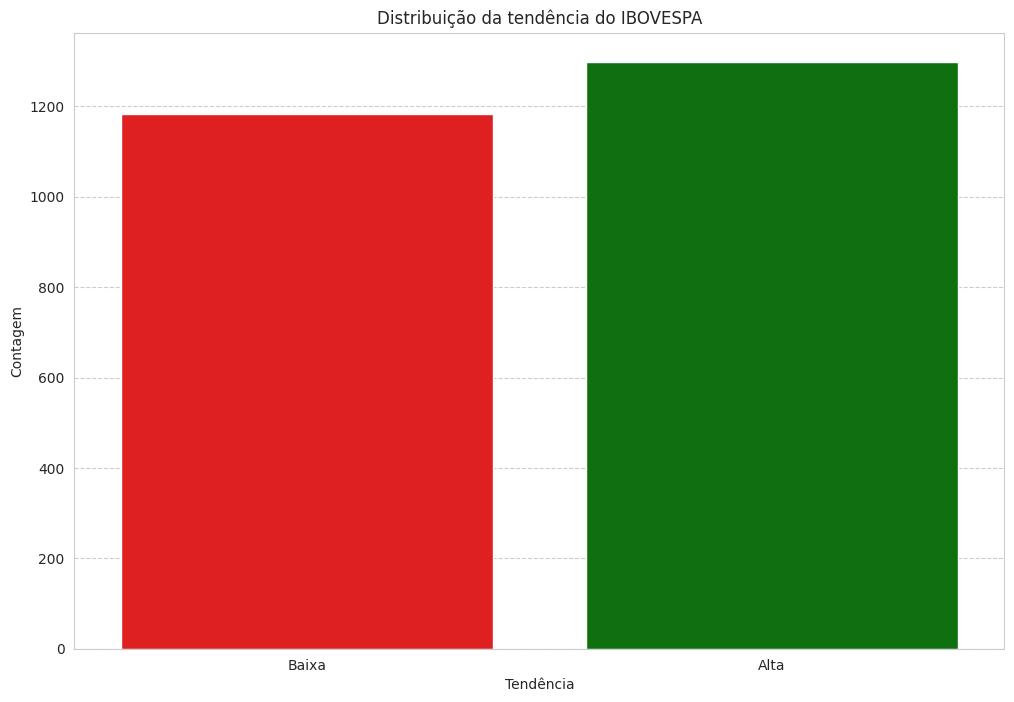

In [304]:
# Fazendo um plot da variável alvo para conferir quantos dias terminou em alta / baixa
palette_green_red = {0: 'red', 1: 'green'}

plt.figure(figsize=(12, 8))
sns.countplot(data=df_10years, x='target', hue='target', palette=palette_green_red, legend=False)
plt.title('Distribuição da tendência do IBOVESPA')
plt.xlabel('Tendência')
plt.ylabel('Contagem')
plt.xticks(ticks=[0, 1], labels=['Baixa', 'Alta'])
plt.show()

In [305]:
# Porcentagem da distribuição da tendência
df_10years['target'].value_counts(normalize=True)

target
1    0.523176
0    0.476824
Name: proportion, dtype: float64

Após a análise da distribuição da variável alvo, verificamos que o dataset é naturalmente balanceado. Portanto, a aplicação de técnicas de reamostragem como *oversampling* ou *undersampling* não se faz necessária.

## VOLUME

In [306]:
import yfinance as yf
dados_yf = yf.download('^BVSP', start='2015-06-01', end='2025-06-19')
dados_yf.tail()

/tmp/ipykernel_21165/4233849748.py:2: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^BVSP,^BVSP,^BVSP,^BVSP,^BVSP
Date,,,,,
2025-06-12,137800.0,137931.0,136175.0,137127.0,7124600
2025-06-13,137213.0,137800.0,136586.0,137800.0,8628300
2025-06-16,139256.0,139988.0,137212.0,137212.0,7620500
2025-06-17,138840.0,139497.0,138293.0,139256.0,8377000
2025-06-18,138717.0,139161.0,138443.0,138844.0,8323400


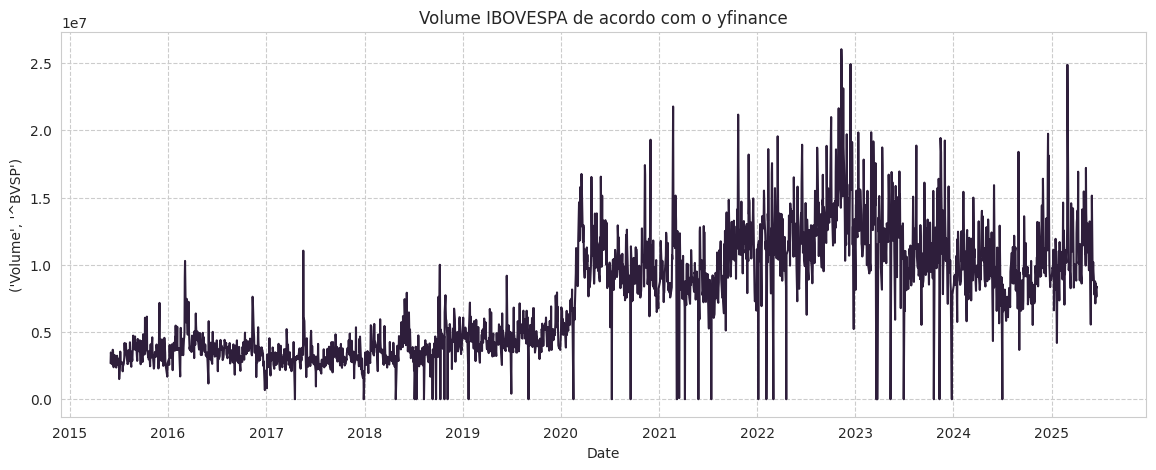

In [307]:
plt.figure(figsize=(14, 5))
ax = sns.lineplot(dados_yf, x=dados_yf.index, y=('Volume', '^BVSP'))
plt.title('Volume IBOVESPA de acordo com o yfinance')
ax.xaxis.set_major_locator(mdates.YearLocator(base=1))

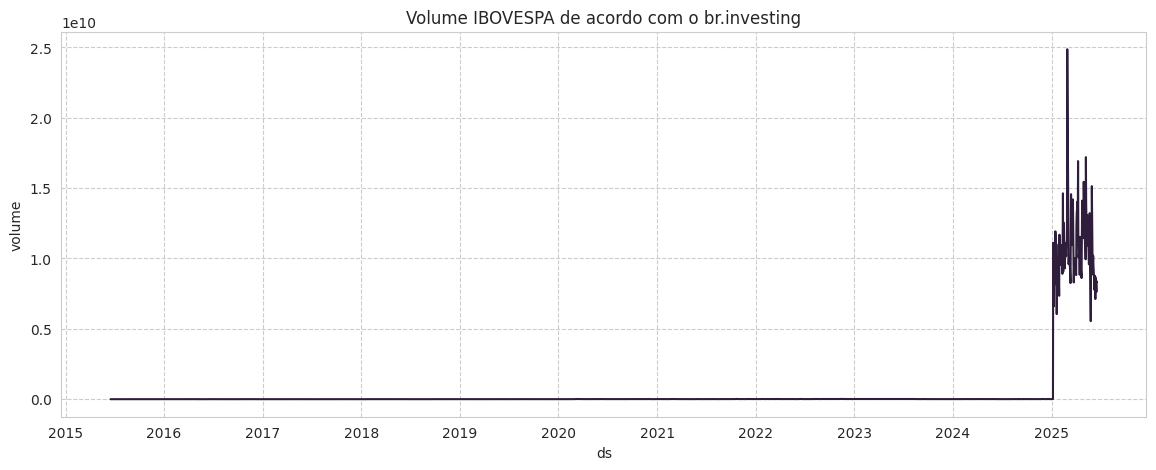

In [308]:
plt.figure(figsize=(14, 5))
ax =sns.lineplot(df_10years, x=df_10years.index, y='volume')
plt.title('Volume IBOVESPA de acordo com o br.investing')
ax.xaxis.set_major_locator(mdates.YearLocator(base=1))